In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold

#The model
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
# from mlens.ensemble import SuperLearner


#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings 
warnings.simplefilter("ignore")

In [183]:
l1=[0,1,0,1,0,1]
la=[1,0,1,0,1,1]
l2=[1,1,0,0,1,0]

lo=[]
lo.append(l1)
lo.append(la)
lo.append(l2)

array=np.array(lo)
print(array)
arr=np.zeros(array.shape[1])
arr

[[0 1 0 1 0 1]
 [1 0 1 0 1 1]
 [1 1 0 0 1 0]]


array([0., 0., 0., 0., 0., 0.])

In [184]:
for i in range(array.shape[1]):
    # a=1 if array[:,i:i+1].sum() > array.shape[0]/2 else 0
    arr[i]=1 if array[:,i:i+1].sum() > array.shape[0]/2 else 0

In [185]:
arr

array([1., 1., 0., 0., 1., 1.])

In [186]:
array.shape

(3, 6)

In [187]:
lo[0][0]=-100
lo

[[-100, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0]]

In [188]:
array[0][0]=-400
array

array([[-400,    1,    0,    1,    0,    1],
       [   1,    0,    1,    0,    1,    1],
       [   1,    1,    0,    0,    1,    0]])

In [189]:
arr

array([1., 1., 0., 0., 1., 1.])

In [190]:
class AnomalyDetectionDataLoader:
    
    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = MinMaxScaler()

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        
        self.data.drop_duplicates(keep="last", inplace=True)

        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def preprocess_data(self):

        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):
        
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler



In [191]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1
        
    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1
        
    elif isinstance(target,np.ndarray): 
        target[target==1]=0
        target[target==-1]=1
    return target

In [192]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
 
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytest,ypred)

In [193]:
class CustomGridSearchCV:
    
    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):
        
        f1_scorer = make_scorer(f1_score)
        param_grid = ParameterGrid(self.param_grid)
        skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)
        
        for params in tqdm(param_grid):
            
            
            total_score = 0

            # Itérer sur les plis de la validation croisée
            for train_index, val_index in tqdm(skf.split(X,y)):
                xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
                ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

                # Entraîner le modèle
                model = self.estimator.set_params(**params)
                model.fit(xtrain_fold)

                # Faire des prédictions
                ypred_val = model.predict(xval_fold)
                ypred_val = inverse_transform_target(ypred_val)

                current_score = f1_score(ypred_val, yval_fold)

                total_score += current_score

            avg_score = total_score / self.n_splits

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,xtest):
        return self.best_estimator.predict(xtest)

In [199]:
class CustomVoting:

    def __init__(self, estimators):

        self.estimators= estimators
        # self.voting_labels=None
        self.current_estimator=None


    def predict_base_model(self,model,xtest):

        ypred=None
        
        if isinstance(model,LocalOutlierFactor):
            ypred=model.fit_predict(xtest)
            
        elif isinstance(model,OneClassSVM):
            ypred=model.predict(xtest)

        elif isinstance(model,IsolationForest):
            ypred=model.predict(xtest)

        return ypred


    def voting(self, bases_predictions):

        vote_labels=np.zeros(bases_predictions.shape[1])
        for i in range(bases_predictions.shape[1]):
            vote_labels[i]=1 if bases_predictions[:,i:i+1].sum() > array.shape[0]/2 else 0

        return vote_labels
        
    def fit(self,xtrain):

    
        for name, model in tqdm(self.estimators):
            print("==========================")
            print(name)
            model.fit(xtrain)

    def predict(self,xtest):
        
        labels=[]
        for name, model in tqdm(self.estimators):
            # self.current_estimator=model
            ypred=self.predict_base_model(model,xtest)
            # if ypred==None:
            #     raise "Wrong prediction"
            ypred=inverse_transform_target(ypred)
            labels.append(ypred)

        return self.voting(np.array(labels))
            
        

In [200]:
# Utilisation de la classe
data_loader = AnomalyDetectionDataLoader(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv")
data_loader.load_data()
data_loader.preprocess_data()
data_loader.split_data()

xtrain, ytrain = data_loader.get_train_data()
xtest, ytest = data_loader.get_test_data()
scaler = data_loader.get_scaler()


In [201]:
params_SVM={'kernel': 'poly', 'nu': 0.0026,'gamma':'auto','degree':9}
one_svm=OneClassSVM(**params_SVM)

params_lof={'contamination': 0.003, 'n_neighbors': 140}
lof=LocalOutlierFactor(**params_lof)

params_iforest={'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 600}
iforest=IsolationForest(**params_iforest)

estimators=[('one_smv', one_svm),('lof',lof),('iforest',iforest)]

model=CustomVoting(estimators)

In [202]:
model.fit(xtrain)

  0%|          | 0/3 [00:00<?, ?it/s]

one_smv
lof
iforest


  0%|          | 0/3 [00:00<?, ?it/s]

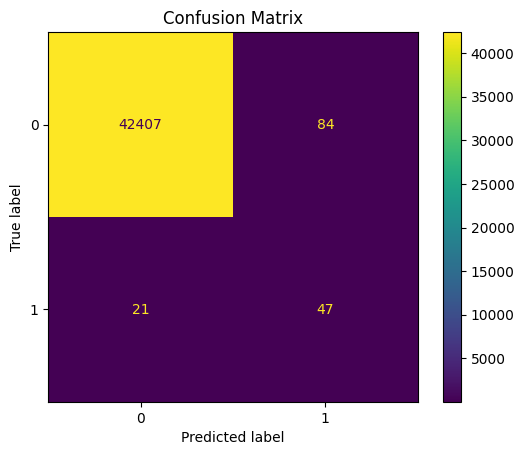

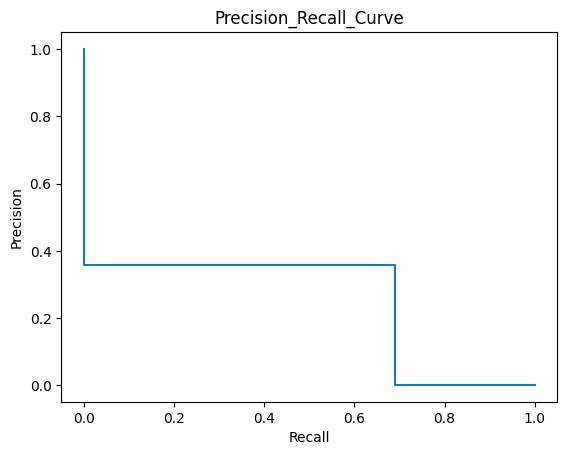

roc_auc 0.8445997906823175


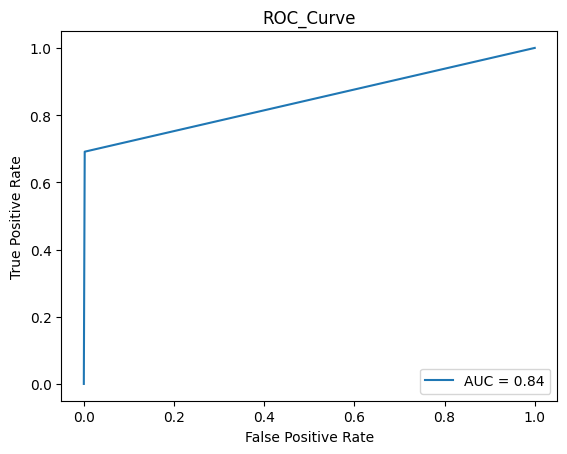

   f1_score  accuracy_score  precision_score  recall_score
0  0.472362        0.997533         0.358779      0.691176


In [203]:
ypred=model.predict(xtest)
evaluation(ytest,ypred)